# Guideline on Eager Execution

* 이 코드는 [TensorFlow official Guide `eager execution` 문서](https://www.tensorflow.org/guide/eager)를 정리한 것이다.

[Eager execution](https://www.tensorflow.org/guide/eager#build_a_model) is a flexible machine learning platform for research and experimentation, providing:

* **An intuitive interface**: Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.
* **Easier debugging**: Call ops directly to inspect running models and test changes. Use standard Python debugging tools for immediate error reporting.
* **Natural control flow**: Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

print(tf.VERSION)

1.14.0


## Guideline on building a model

* Use only [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers), do **NOT** use `tf.layers` or `tf.contrib.layers`.

### Example of a layer made myself

In [2]:
class MySimpleLayer(tf.keras.layers.Layer):
  def __init__(self, output_units):
    super(MySimpleLayer, self).__init__()
    self.output_units = output_units

  def build(self, input_shape):
    # The build method gets called the first time your layer is used.
    # Creating variables on build() allows you to make their shape depend
    # on the input shape and hence removes the need for the user to specify
    # full shapes. It is possible to create variables during __init__() if
    # you already know their full shapes.
    self.kernel = self.add_variable(
      "kernel", [input_shape[-1], self.output_units])

  def call(self, input):
    # Override call() instead of __call__ so we can perform some bookkeeping.
    return tf.matmul(input, self.kernel)

### Simple method of building a model
* Use [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential)
* Must set input shape

In [3]:
model = tf.keras.Sequential([
  layers.Dense(10, input_shape=(784,)),  # must declare input shape
  layers.Dense(10)
])

### Another method of builing a model

* Organize models in classes by inheriting from [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model).
* It's not required to set an input shape for the [`tf.keras.Model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model) class since the parameters are set the first time input is passed to the layer.
* [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) classes create and contain their own model variables that are tied to the lifetime of their layer objects. To share layer variables, share their objects.

In [4]:
class MNISTModel(tf.keras.Model):
  def __init__(self):
    super(MNISTModel, self).__init__()
    self.dense1 = layers.Dense(units=10)
    self.dense2 = layers.Dense(units=10)

  def call(self, input):
    """Run the model."""
    result = self.dense1(input)
    result = self.dense2(result)
    result = self.dense2(result)  # reuse variables from dense2 layer
    return result

model = MNISTModel()

## Eager Training

### Computing gradients
* Use [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape)

In [5]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### Train a model

In [6]:
# Fetch and format the mnist data
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[..., tf.newaxis]/255., tf.float32), # [..., tf.newaxis] for just expand_dims(last_axis)
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [7]:
# Build the model
mnist_model = tf.keras.Sequential([
  layers.Conv2D(16, [3,3], activation='relu'),
  layers.Conv2D(16, [3,3], activation='relu'),
  layers.GlobalAveragePooling2D(),
  layers.Dense(10)
])

In [8]:
# without training, just inference a model in eager execution:
for images,labels in dataset.take(1):
  print("Logits: ", mnist_model(images[0:1]).numpy())

Logits:  [[ 0.00685952  0.03932749 -0.0134522   0.00282345  0.01445247  0.00431713
  -0.04481236  0.01483524  0.04638922 -0.05782087]]


In [9]:
# Train the model
optimizer = tf.train.AdamOptimizer()
loss_history = []

In [10]:
for (batch, (images, labels)) in enumerate(dataset.take(400)): # just 400 steps (iterations), NOT epochs
  if batch % 80 == 0:
    print()
  print('.', end='')
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, mnist_model.variables)
  optimizer.apply_gradients(zip(grads, mnist_model.variables),
                            global_step=tf.train.get_or_create_global_step())


................................................................................
................................................................................
................................................................................
................................................................................
................................................................................

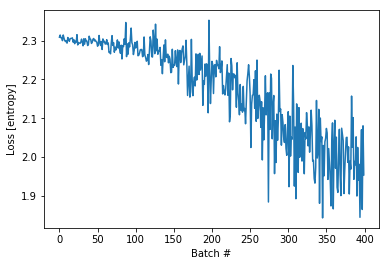

In [11]:
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')
plt.show()

### Train a model made myself

In [12]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')

  def call(self, inputs):
    return inputs * self.W + self.B

In [13]:
# A toy dataset of points around 3 * x + 2
NUM_EXAMPLES = 2000
training_inputs = tf.random_normal([NUM_EXAMPLES])
noise = tf.random_normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

In [14]:
# The loss function to be optimized
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

In [15]:
# Define:
# 1. A model.
# 2. Derivatives of a loss function with respect to model parameters.
# 3. A strategy for updating the variables based on the derivatives.
model = Model()
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

print("Initial loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# Training loop
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]),
                            global_step=tf.train.get_or_create_global_step())
  if i % 20 == 0:
    print("Loss at step {:03d}: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("Final loss: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

Initial loss: 68.421
Loss at step 000: 65.760
Loss at step 020: 29.942
Loss at step 040: 13.932
Loss at step 060: 6.776
Loss at step 080: 3.577
Loss at step 100: 2.147
Loss at step 120: 1.507
Loss at step 140: 1.222
Loss at step 160: 1.094
Loss at step 180: 1.037
Loss at step 200: 1.011
Loss at step 220: 1.000
Loss at step 240: 0.995
Loss at step 260: 0.992
Loss at step 280: 0.991
Final loss: 0.991
W = 3.0063259601593018, B = 2.0391414165496826


### Save a model

In [16]:
model = tf.keras.Sequential([
  layers.Conv2D(16, [3,3], activation='relu'),
  layers.GlobalAveragePooling2D(),
  layers.Dense(10)
])

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

checkpoint_dir = './model_dir'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model,
                           optimizer_step=tf.train.get_or_create_global_step())

In [17]:
# Save a model
root.save(checkpoint_prefix)

'./model_dir/ckpt-1'

In [18]:
# Restore a model
root.restore(tf.train.latest_checkpoint(checkpoint_dir))